In [1]:
%load_ext autoreload
%autoreload 2

%aimport xclimate

In [1]:
from pathlib import Path

import numpy as np
import xarray as xr
import matplotlib as mpl
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import xclimate as xclim

In [2]:
d = Path("/glade/work/bbuchovecky/et_controls/proc/qbin")
d / "a" / "b"

PosixPath('/glade/work/bbuchovecky/et_controls/proc/qbin/a/b')

In [3]:
time_slice = slice("1995-01", "2014-12")
year_start = time_slice.start[:4]
year_end = time_slice.stop[:4]
grid = xclim.load_fhist_ppe_grid()

snow_pct_threshold = 80    # maximum allowable percent of snow cover on all months of the average year
nonglc_pct_threshold = 80  # maximum allowable percent of glaciated land for a NON-glaciated gridcell

fsno = xclim.load_fhist("FSNO_month_1", keep_var_only=True)["FSNO"].sel(time=time_slice).reindex_like(grid, method="nearest", tolerance=1e-3)
fsno_clim_min = fsno.groupby("time.month").mean().min(dim="month")

# Create masks
snow_mask = fsno_clim_min <= (snow_pct_threshold / 100)
nonglc_mask = grid.PCT_GLC <= nonglc_pct_threshold
full_mask = snow_mask & nonglc_mask

variables = [
    # "PRECC_month_1", "PRECL_month_1",
    "TSA_month_1",
    # "TLAI_month_1",
    # "EFLX_LH_TOT_month_1",
    # "PRECT_day_1", "TSA_day_1",
    # "FSDS_month_1", "FSR_month_1", "FLDS_month_1", "FIRE_month_1",

]
time_slice = slice("1995-01", "2014-12")
n_qbin = np.array([15, 25, 50, 75, 100])

rootdir = Path("/glade/work/bbuchovecky/et_controls/proc/quantiles")
time_tag = "agg"


print("Loading variables:")
fhist = {}
for v in variables:
    print(f"  {v}")
    name = "_".join(v.split("_")[:-2])
    fhist[v] = xclim.load_fhist(v, keep_var_only=True)[name].sel(time=time_slice).reindex_like(grid, method="nearest", tolerance=1e-3)
    fhist[v] = fhist[v].where(full_mask)
    fhist[v].attrs["masks"] = f"gridcell percent glaciated land <= {nonglc_pct_threshold}\ngridcell percent snow cover on all months of average year <= {snow_pct_threshold}"


Loading variables:
  TSA_month_1


In [4]:
tdim = "time"
chunks = {"member": 1, "lat": 48, "lon": 72, tdim: -1}

fhist["TSA_month_1"].chunk(chunks)

<xarray.DataArray 'TSA' (member: 27, time: 240, lat: 96, lon: 144)> Size: 358MB
dask.array<rechunk-merge, shape=(27, 240, 96, 144), dtype=float32, chunksize=(1, 240, 48, 72), chunktype=numpy.ndarray>
Coordinates:
  * member    (member) int64 216B 0 1 2 3 4 5 6 7 8 ... 20 21 22 23 24 25 26 27
  * time      (time) object 2kB 1995-01-01 00:00:00 ... 2014-12-01 00:00:00
  * lat       (lat) float64 768B -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon       (lon) float64 1kB 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
    ltype     int64 8B ...
    landunit  <U40 160B ...
Attributes:
    long_name:     2m air temperature
    units:         K
    cell_methods:  time: mean
    masks:         gridcell percent glaciated land <= 80\ngridcell percent sn...

In [ ]:
# Center month of the climatological growing season, defined as the three adjacent months with the greatest climatological LAI
x = fhist["TLAI_month_1"].groupby("time.month").mean()  # first compute the LAI climatology over the time period
fhist["GROWSNMON_clim"] = (
    xr.concat(
        [
            x.isel(month=slice(-1, None)),  # last month
            x,
            x.isel(month=slice(0, 1)),      # first month
        ],    
        dim="month")
    .rolling(month=3, center=True).mean()  # compute the 3-month rolling mean
    .isel(month=slice(1, -1))  # remove padding
    .fillna(-np.inf)  # fill NaN with -inf so argmax doesn't fail
    .argmax(dim="month") + 1  # get the center month, 1=Jan
)
fhist["GROWSNMON_clim"] = fhist["GROWSNMON_clim"].rename("GROWSNMON")
fhist["GROWSNMON_clim"].attrs = {
    "long_name": f"center month of the climatological growing season [1=Jan, 12=Dec]",
    "description": "growing season is defined as the three adjacent months with the greatest climatological LAI",
}

# Center month of the growing season each year, where growing season is defined as the three adjacent months with the greatest mean LAI during a year
fhist["GROWSNMON_year_1"] = fhist["TLAI_month_1"].groupby("time.year").map(
    lambda x: xr.concat(
            [
                x.isel(time=slice(-1, None)),  # last month
                x, 
                x.isel(time=slice(0, 1))       # last month
            ],
            dim="time")
        .rolling(time=3, center=True).mean()  # compute the 3-month rolling mean
        .isel(time=slice(1, -1))  # remove padding
        .fillna(-np.inf)  # fill NaN with -inf so argmax doesn't fail
        .argmax(dim="time") + 1  # get the center month, 1=Jan
)
fhist["GROWSNMON_year_1"] = fhist["GROWSNMON_year_1"].rename("GROWSNMON")
fhist["GROWSNMON_year_1"].attrs = {
    "long_name": f"center month of the annual growing season [1=Jan, 12=Dec]",
    "description": "growing season is defined as the three adjacent months with the greatest LAI",
}

# Annual growing season LAI, where growing season is defined as the three adjacent months with the greatest mean LAI during a year
fhist["GROWSNLAI_year_1"] = fhist["TLAI_month_1"].chunk({"time": -1}).groupby("time.year").map(
    lambda x: xr.concat(
            [
                x.isel(time=slice(-1, None)),  # last month
                x, 
                x.isel(time=slice(0, 1))       # first month
            ],
            dim="time")
        .rolling(time=3, center=True).mean()  # compute the 3-month rolling mean
        .isel(time=slice(1, -1))  # remove padding
        .max(dim="time", skipna=True)  # select the 3-month period with the greatest mean
)
fhist["GROWSNLAI_year_1"] = fhist["GROWSNLAI_year_1"].rename("GROWSNLAI")
fhist["GROWSNLAI_year_1"].attrs = {
    "long_name": f"annual growing season {fhist['TLAI_month_1'].name}",
    "description": "growing season is defined as the three adjacent months during a year with the greatest LAI",
    "units": fhist['TLAI_month_1'].units,
}

# Monthly net radiation at the surface, + down
#   Rn = (net SW) + (net LW) = (down SW - up SW) - (down LW - up LW)
#   Rn = FSDS - FSR + FLDS - FIRE
fhist["RN_month_1"] = fhist["FSDS_month_1"] - fhist["FSR_month_1"] + fhist["FLDS_month_1"] - fhist["FIRE_month_1"]
fhist["RN_month_1"] = fhist["RN_month_1"].rename("RN")
fhist["RN_month_1"].attrs = {
    "long_name": "net radiation at surface [+ down]",
    "description": "FSDS - FSR + FLDS - FIRE",
    "units": "W/m2",
}

# Climatological net radiation at the surface
fhist["RN_clim"] = fhist["RN_month_1"].weighted(fhist["RN_month_1"].time.dt.days_in_month).mean("time")
fhist["RN_clim"].attrs["time_mean"] = f"{time_slice.start} to {time_slice.stop}"

# Monthly precipitation rate (PRECC + PRECL)
fhist["PRECT_month_1"] = (fhist["PRECC_month_1"] + fhist["PRECL_month_1"]) * 1000 * 2.5e6
fhist["PRECT_month_1"] = xr.where(fhist["PRECT_month_1"] < 1e-3, 1e-3, fhist["PRECT_month_1"])
fhist["PRECT_month_1"].attrs["units"] = "W/m2"

# Climatological precipitation rate
fhist["PRECT_clim"] = fhist["PRECT_month_1"].weighted(fhist["PRECT_month_1"].time.dt.days_in_month).mean("time")
fhist["PRECT_clim"].attrs["time_mean"] = f"{time_slice.start} to {time_slice.stop}"

# Climatological aridity index (AI = PET / P = RN / PRECT)
fhist["AI_clim"] = fhist["RN_clim"] / fhist["PRECT_clim"]
fhist["AI_clim"] = fhist["AI_clim"].rename("AI")
fhist["AI_clim"].attrs = {
    "long_name": "aridity index PET/P, higher is more arid",
    "description": "Rn / (Lv * P), filtered P = max(P, 0.001) [W/m2]",
    "time_mean": f"{time_slice.start} to {time_slice.stop}"
}

# Climatological inverse aridity index (INVAI = P / PET = PRECT / RN)
fhist["INVAI_clim"] = fhist["PRECT_clim"] / fhist["RN_clim"]
fhist["INVAI_clim"] = fhist["INVAI_clim"].rename("INVAI")
fhist["INVAI_clim"].attrs = {
    "long_name": "inverse aridity index P/PET, lower is more arid",
    "description": "(Lv * P) / Rn, filtered P = max(P, 0.001) [W/m2]",
    "time_mean": f"{time_slice.start} to {time_slice.stop}"
}

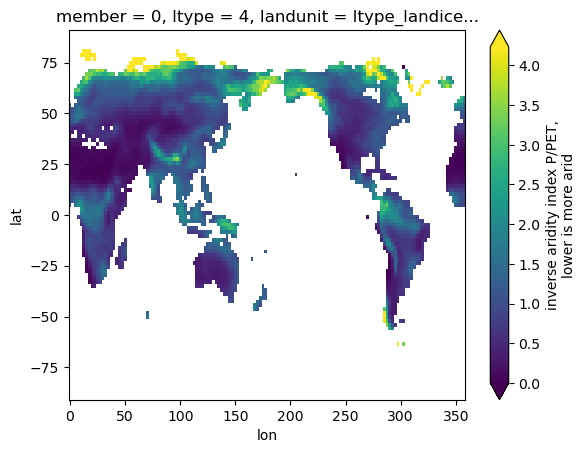

In [37]:
fhist["INVAI_clim"].where(nonglc_mask & snow_mask).sel(member=0).plot(robust=True, vmin=0)

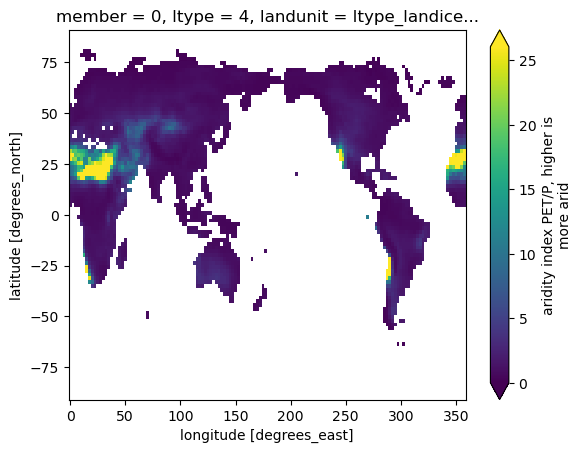

In [38]:
fhist["AI_clim"].where(nonglc_mask & snow_mask).sel(member=0).plot(robust=True, vmin=0)

In [40]:
xclim.science.growing_season_month(fhist["TLAI_month_1"])

<xarray.DataArray 'growsn_center_month' (member: 27, lat: 96, lon: 144)> Size: 3MB
dask.array<add, shape=(27, 96, 144), dtype=int64, chunksize=(1, 96, 144), chunktype=numpy.ndarray>
Coordinates:
  * member   (member) int64 216B 0 1 2 3 4 5 6 7 8 ... 20 21 22 23 24 25 26 27
  * lat      (lat) float64 768B -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon      (lon) float64 1kB 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Attributes:
    long_name:    center month of the climatological growing season [1=Jan, 1...
    description:  growing season is defined as the 3 adjacent months with the...

In [42]:
fhist["TLAI_month_1"]

<xarray.DataArray 'TLAI' (member: 27, time: 24, lat: 96, lon: 144)> Size: 36MB
dask.array<getitem, shape=(27, 24, 96, 144), dtype=float32, chunksize=(1, 1, 96, 144), chunktype=numpy.ndarray>
Coordinates:
  * member   (member) int64 216B 0 1 2 3 4 5 6 7 8 ... 20 21 22 23 24 25 26 27
  * time     (time) object 192B 1995-01-01 00:00:00 ... 1996-12-01 00:00:00
  * lat      (lat) float64 768B -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon      (lon) float64 1kB 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Attributes:
    long_name:     total projected leaf area index
    units:         m^2/m^2
    cell_methods:  time: mean

In [41]:
xclim.science.growing_season_mean(fhist["TLAI_month_1"], fhist["TLAI_month_1"])

<xarray.DataArray 'TLAI' (member: 27, lat: 96, lon: 144)> Size: 1MB
dask.array<mean_agg-aggregate, shape=(27, 96, 144), dtype=float32, chunksize=(1, 96, 144), chunktype=numpy.ndarray>
Coordinates:
  * member   (member) int64 216B 0 1 2 3 4 5 6 7 8 ... 20 21 22 23 24 25 26 27
  * lat      (lat) float64 768B -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon      (lon) float64 1kB 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Attributes:
    long_name:     total projected leaf area index
    units:         m^2/m^2
    cell_methods:  time: mean

In [70]:
nmon = 3
pad = nmon // 2

# Get the center month for each gridcell
center = fhist["GROWSNMON_clim"]

# Compute distance from center month (handling wraparound: Dec->Jan)
month_nums = xr.DataArray(
    data=np.arange(1, 13),
    dims=["month"],
    coords={"month": np.arange(1, 13)}
)
dist = ((month_nums - center + 6) % 12) - 6  # range: -6 to +5

# Select months within +/-1 of center (the 3-month window)
mask = np.abs(dist) <= pad

# Compute the mean over those 3 months
# Extract months from time coordinate and align with mask
rn_growsn = fhist["RN_month_1"].groupby("time.year").map(
    lambda x: x.where(mask.sel(month=x.time.dt.month)).mean(dim="time")
)

In [ ]:
nmon = 3
pad = nmon // 2

# Get the center month for each gridcell
center = fhist["GROWSNMON_clim"]

# Compute distance from center month (handling wraparound: Dec->Jan)
month_nums = xr.DataArray(
    data=np.arange(1, 13),
    dims=["month"],
    coords={"month": np.arange(1, 13)}
)
dist = ((month_nums - center + 6) % 12) - 6  # range: -6 to +5

# Select months within +/-1 of center (the 3-month window)
mask = np.abs(dist) <= pad

def _process_year(yearly_data):
    """
    Compute the annual mean of a specified subset of months.
    
    yearly_data has dims: (time: 12, member: N, lat: M, lon: L)
    """    
    # Extract month numbers for this year (1-12)
    months = yearly_data.time.dt.month
    
    # Get the mask values for these specific months
    mask_for_year = mask.sel(month=months)
    
    # Apply the mask (set False values to NaN)
    masked_data = yearly_data.where(mask_for_year)
    
    # Compute mean over time dimension (collapse 12 months to 1 value)
    result = masked_data.mean(dim="time")
    
    return result

# Apply it to each year
rn_growsn_verbose = fhist["RN_month_1"].groupby("time.year").map(_process_year)

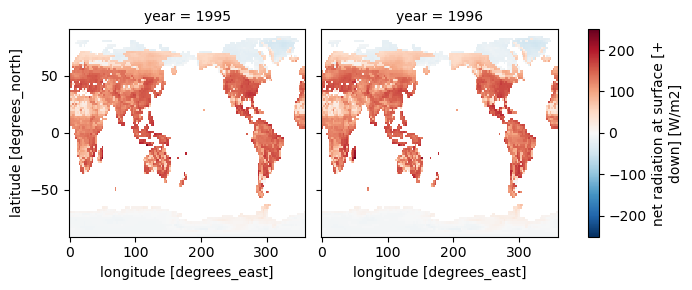

In [69]:
rn_growsn_verbose.sel(member=0).plot.pcolormesh(col="year")

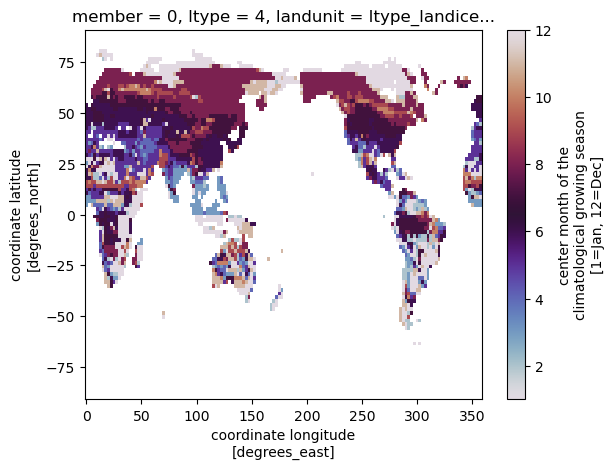

In [150]:
center.where(nonglc_mask & snow_mask).isel(member=0).plot(cmap="twilight", vmin=1, vmax=12)

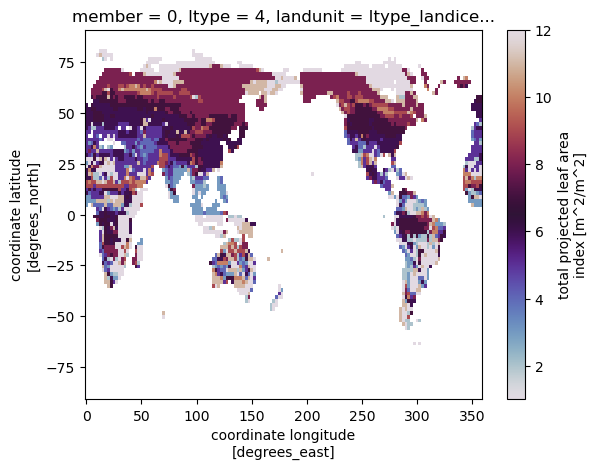

In [ ]:
# This computes the center month of the three month growing season
x = fhist["TLAI_month_1"].groupby("time.month").mean()
x = (
    xr.concat(
        [
            x.isel(month=slice(-1, None)),  # last month
            x,
            x.isel(month=slice(0, 1)),      # first month
        ],    
        dim="month")
    .rolling(month=3, center=True).mean()
    .isel(month=slice(1, -1))  # remove padding
    .fillna(-np.inf)  # fill NaN with -inf so argmax doesn't fail
    .argmax(dim="month") + 1
)
x.where(nonglc_mask & snow_mask).isel(member=0).plot(cmap="twilight", vmin=1, vmax=12)

In [ ]:
x = fhist["TLAI_month_1"].sel(time=slice("1995-01", "1995-12"), member=0)
xs = np.sort(x.values, axis=0)[-3:, :, :].mean(axis=0)
xs_da = xr.DataArray(
    data=xs,
    dims=["lat", "lon"],
    coords={
        "lat": x.lat,
        "lon": x.lon,
    }
)

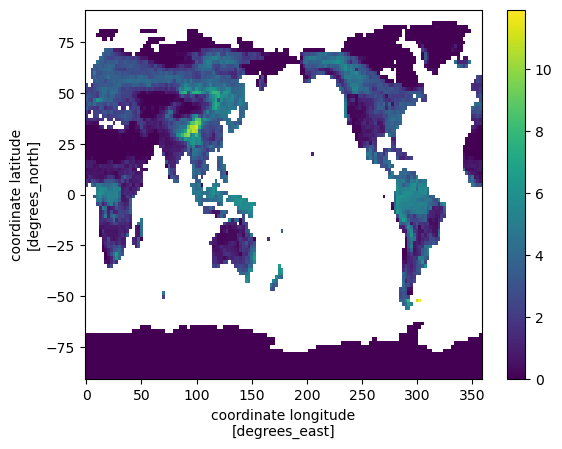

In [57]:
xs_da.plot()

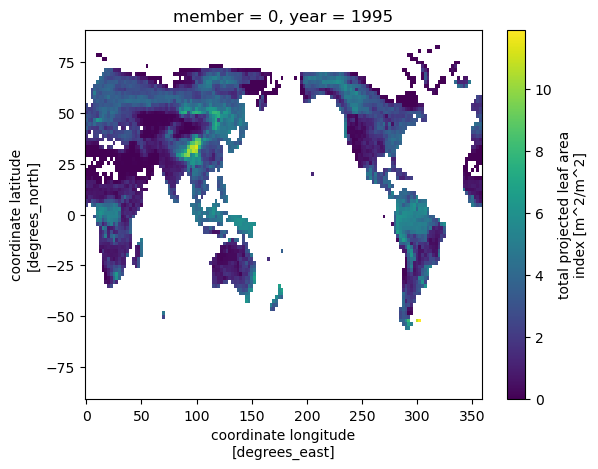

In [11]:
fhist["GRSNLAI_year_1"].sel(year=1995, member=0).plot()